<a href="https://colab.research.google.com/github/Haebuk/Python_Machine_Learning/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms  
import torchvision
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 23 08:42:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 150

In [ ]:
data_dir_Train = '/content/drive/MyDrive/input/programmers/train'
data_dir_Test = '/content/drive/MyDrive/input/programmers/test'

train_dir = data_dir_Train + '/train'
test_dir = data_dir_Test + '/test'

outcomes = os.listdir(train_dir)

In [ ]:
print(outcomes)

['elephant', 'giraffe', 'guitar', 'house', 'horse', 'dog', 'person']


## Augmentation

In [ ]:
# 이미지 정규화 및 좌우 반전 증강
transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# Test 데이터는 정규화만
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [ ]:
train_data = torchvision.datasets.ImageFolder(root = train_dir,
                                              transform=transform)
test_data = torchvision.datasets.ImageFolder(root = test_dir,
                                              transform=transform_tests)

valid_size = 0.2
# train 데이터  validation 데이터로 나누기
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, sampler = train_sampler, num_workers = 2)
valid_loader = DataLoader(train_data, batch_size = 2 * BATCH_SIZE, sampler = valid_sampler, num_workers = 3)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = False, num_workers = 2)

In [ ]:
train_on_gpu = torch.cuda.is_available() 

## Using Pretrained Model

- pretrained model은 비교적 최신에 나오고 가벼운 efficientnet을 사용

- 버전은 우리 사진 데이터가 227*227이기 때문에 224*224를 인풋으로 받는 b0를 사용

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0' 

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
# 클래스가 7개이므로 마지막에 7개로 분류하는 레이어 추가
model = EfficientNet.from_pretrained(model_name, num_classes=7)

224
Loaded pretrained weights for efficientnet-b0


In [ ]:
model
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
# loss function, optimizer 설정
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lmbda = lambda epoch: 0.98739
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

## Train Model

In [ ]:
# train epoch 설정
epochs = EPOCHS

# loss 추적
valid_loss_min = np.Inf
val_loss = []
tn_loss = []
for epoch in range(1,epochs+1):

    # train/ validation loss 초기화
    train_loss = 0.0
    valid_loss = 0.0

    # 모델 훈련

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):       
        
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # optimizer 초기화
        optimizer.zero_grad()
        # 계산
        output = model(data)
        # loss 계산
        loss = criterion(output, target)
        # 그래디언트 계산
        loss.backward()
        # optimizer 업데이트
        optimizer.step()
        
        # train loss 업데이트
        train_loss += loss.item()*data.size(0)

    # 모델 검증

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            
            if train_on_gpu:
                data, target = data.to(device), target.to(device)
            # 계산
            output = model(data)
            # loss 계산
            loss = criterion(output, target)
            # validation loss 업데이트
            valid_loss += loss.item()*data.size(0)
    
    # 평균 loss 계산
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    # learning rate 업데이트
    scheduler.step()
    # loss statistics 출력
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    # validation loss 감소할 경우 모델 저장
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        # 현재 모델 저장
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss
    print('Learning Rate ------------->{:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

Epoch: 1 	 Training Loss: 1.443 	 Validation Loss: 493821.223
Validation loss decreased inf--->493821.2234  Saving model...
Learning Rate ------------->0.0099
Epoch: 2 	 Training Loss: 1.006 	 Validation Loss: 11153979.870
Learning Rate ------------->0.0097
Epoch: 3 	 Training Loss: 0.768 	 Validation Loss: 425614.029
Validation loss decreased 493821.2234--->425614.0295  Saving model...
Learning Rate ------------->0.0096
Epoch: 4 	 Training Loss: 0.505 	 Validation Loss: 166017.981
Validation loss decreased 425614.0295--->166017.9811  Saving model...
Learning Rate ------------->0.0095
Epoch: 5 	 Training Loss: 0.360 	 Validation Loss: 7911.787
Validation loss decreased 166017.9811--->7911.7866  Saving model...
Learning Rate ------------->0.0094
Epoch: 6 	 Training Loss: 0.273 	 Validation Loss: 413.431
Validation loss decreased 7911.7866--->413.4310  Saving model...
Learning Rate ------------->0.0093
Epoch: 7 	 Training Loss: 0.166 	 Validation Loss: 241.995
Validation loss decreased 4

## 훈련/ 검증 loss 그래프 비교

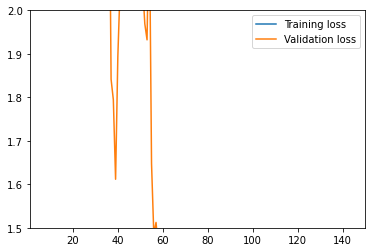

In [ ]:
plt.plot(tn_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlim(1,epoch)
plt.ylim(1.5,2)
plt.legend()
plt.show()

## Load Saved Parameters

In [ ]:
model.load_state_dict(torch.load('model_state.pt'))
model.eval()
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

## Predictions on test Dataset

In [ ]:
running_loss, running_corrects, num_cnt = 0.0, 0, 0
results = []
with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            results.appen()
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_cnt += images.size(0)
        test_loss = running_loss / num_cnt
        test_acc = running_corrects.double() / num_cnt
    
print('Number of image Tested=', num_cnt)
print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

Number of image Tested= 350
test done : loss/acc : 12.66 / 13.1


## Image Predictions

In [ ]:
preds.

AttributeError: ignored